<a href="https://colab.research.google.com/github/paishowstopper/TSAI/blob/main/EVA5/Session_6/Session_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train_set = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments


In [4]:
SEED = 1
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

Common parameters initialized to default values

In [5]:
dropout_value = 0.0
num_splits = 2
lambda_l1 = 0

# Ghost Batch Normalization (Extracted from https://github.com/apple/ml-cifar-10-faster/blob/master/utils.py)

In [6]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

Function to select Ghost or regular batch normalizarion

In [7]:
def BN_or_GBN(num_features, IsGBN):
  return GhostBatchNorm(num_features, num_splits) if IsGBN else nn.BatchNorm2d(num_features)

# The model
Let's start with the model we first saw

In [8]:
class Net(nn.Module):
    def __init__(self, IsGBN):
        super(Net, self).__init__()

        self.gbn = IsGBN

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            BN_or_GBN(8, self.gbn),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            BN_or_GBN(16, self.gbn),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            BN_or_GBN(16, self.gbn),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            BN_or_GBN(8, self.gbn),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            BN_or_GBN(16, self.gbn),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            BN_or_GBN(16, self.gbn),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(False).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [10]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    #L1 regularization
    l1 = 0
    if lambda_l1:
      l1 = sum(p.abs().sum() for p in model.parameters()) * lambda_l1

    # Calculate loss
    loss = F.nll_loss(y_pred, target) + l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassified_indexes.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
def training(name, l1, w_d, gbn, b_s):

  lambda_l1 = l1
  print('Name:', name, ',Batch Size:', b_s, ',L1:', lambda_l1, ',Weight Decay:', w_d, ',Is GBN:', gbn)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=b_s, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=b_s)
  # train dataloader
  train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

  model =  Net(gbn).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=w_d)
  scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

  EPOCHS = 25
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [12]:
model_parameters = {
    'L1+BN'     : {'l1': 0.01, 'w_d':0, 'gbn': False, 'b_s': 128},
    'L2+BN'     : {'l1': 0, 'w_d':0.01, 'gbn': False, 'b_s': 128},
    'L1+L2+BN'  : {'l1': 0.01, 'w_d':0.01, 'gbn': False, 'b_s': 128},
    'GBN'       : {'l1': 0, 'w_d':0, 'gbn': True, 'b_s': 32},
    'L1+L2+GBN' : {'l1': 0.01, 'w_d':0.01, 'gbn': True, 'b_s': 32}
}

train_losses_all = []
test_losses_all = []
train_acc_all = []
test_acc_all = []
misclassified_all = []

In [13]:
for name in model_parameters.keys():
    
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  misclassified_indexes = []

  training(name, **model_parameters[name])

  train_losses_all.append(train_losses)
  test_losses_all.append(test_losses)
  train_acc_all.append(train_acc)
  test_acc_all.append(test_acc)
  misclassified_all.append(misclassified_indexes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/469 [00:00<?, ?it/s]

Name: L1+BN ,Batch Size: 128 ,L1: 0.01 ,Weight Decay: 0 ,Is GBN: False
EPOCH: 0


Loss=0.032216381281614304 Batch_id=468 Accuracy=91.78: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0613, Accuracy: 9847/10000 (98.47%)

EPOCH: 1


Loss=0.08772719651460648 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9878/10000 (98.78%)

EPOCH: 2


Loss=0.0926235243678093 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.049747198820114136 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.03935795649886131 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 31.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.018256423994898796 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.0031298997346311808 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.005292920861393213 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.03311169892549515 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.033618975430727005 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.07088077068328857 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 31.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.010927792638540268 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 12


Loss=0.014458820223808289 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.002122577978298068 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.05484724044799805 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.008496389724314213 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 16


Loss=0.00691017834469676 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.004821585025638342 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


Loss=0.005363317206501961 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9936/10000 (99.36%)

EPOCH: 19


Loss=0.00402085529640317 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.04503895714879036 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 21


Loss=0.016193946823477745 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.0434451550245285 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


Loss=0.007530956994742155 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.012054354883730412 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

Name: L2+BN ,Batch Size: 128 ,L1: 0 ,Weight Decay: 0.01 ,Is GBN: False
EPOCH: 0


Loss=0.1763954758644104 Batch_id=468 Accuracy=91.43: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1469, Accuracy: 9711/10000 (97.11%)

EPOCH: 1


Loss=0.11333411931991577 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0918, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Loss=0.08680412173271179 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1615, Accuracy: 9696/10000 (96.96%)

EPOCH: 3


Loss=0.13963977992534637 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1043, Accuracy: 9811/10000 (98.11%)

EPOCH: 4


Loss=0.08265235275030136 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9852/10000 (98.52%)

EPOCH: 5


Loss=0.07586698979139328 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0985, Accuracy: 9827/10000 (98.27%)

EPOCH: 6


Loss=0.08059661090373993 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0964, Accuracy: 9823/10000 (98.23%)

EPOCH: 7


Loss=0.031148632988333702 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.04370690882205963 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.08250405639410019 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9931/10000 (99.31%)

EPOCH: 10


Loss=0.03802967444062233 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.05398492515087128 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9938/10000 (99.38%)

EPOCH: 12


Loss=0.05738626793026924 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.07293809205293655 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.061522409319877625 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.04417659342288971 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9943/10000 (99.43%)

EPOCH: 16


Loss=0.061889175325632095 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9944/10000 (99.44%)

EPOCH: 17


Loss=0.07262006402015686 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


Loss=0.04190964624285698 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 31.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9938/10000 (99.38%)

EPOCH: 19


Loss=0.04929528757929802 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


Loss=0.08347573131322861 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


Loss=0.04913295432925224 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.05093633010983467 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.09978900104761124 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.1232963427901268 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9940/10000 (99.40%)

Name: L1+L2+BN ,Batch Size: 128 ,L1: 0.01 ,Weight Decay: 0.01 ,Is GBN: False
EPOCH: 0


Loss=0.15011708438396454 Batch_id=468 Accuracy=91.58: 100%|██████████| 469/469 [00:14<00:00, 31.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1222, Accuracy: 9783/10000 (97.83%)

EPOCH: 1


Loss=0.09874939918518066 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 9865/10000 (98.65%)

EPOCH: 2


Loss=0.07969586551189423 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0766, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.1358170211315155 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1086, Accuracy: 9823/10000 (98.23%)

EPOCH: 4


Loss=0.062016040086746216 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1591, Accuracy: 9658/10000 (96.58%)

EPOCH: 5


Loss=0.09502789378166199 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0994, Accuracy: 9813/10000 (98.13%)

EPOCH: 6


Loss=0.10909175872802734 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0978, Accuracy: 9822/10000 (98.22%)

EPOCH: 7


Loss=0.069675512611866 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.061340466141700745 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9938/10000 (99.38%)

EPOCH: 9


Loss=0.047993626445531845 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.0696345865726471 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.05172828212380409 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.052542794495821 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9932/10000 (99.32%)

EPOCH: 13


Loss=0.06687500327825546 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.04836265742778778 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.049097031354904175 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.0450977087020874 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.05342823639512062 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9946/10000 (99.46%)

EPOCH: 18


Loss=0.042843837291002274 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.05660043656826019 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.03447652980685234 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.032815948128700256 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.038095273077487946 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9943/10000 (99.43%)

EPOCH: 23


Loss=0.06791350990533829 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9943/10000 (99.43%)

EPOCH: 24


Loss=0.05372269079089165 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9944/10000 (99.44%)

Name: GBN ,Batch Size: 32 ,L1: 0 ,Weight Decay: 0 ,Is GBN: True
EPOCH: 0


Loss=0.09678888320922852 Batch_id=1874 Accuracy=94.59: 100%|██████████| 1875/1875 [00:28<00:00, 64.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.02366955205798149 Batch_id=1874 Accuracy=97.78: 100%|██████████| 1875/1875 [00:29<00:00, 64.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9894/10000 (98.94%)

EPOCH: 2


Loss=0.02139483205974102 Batch_id=1874 Accuracy=98.17: 100%|██████████| 1875/1875 [00:29<00:00, 64.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.01792534999549389 Batch_id=1874 Accuracy=98.33: 100%|██████████| 1875/1875 [00:29<00:00, 64.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.0031169503927230835 Batch_id=1874 Accuracy=98.52: 100%|██████████| 1875/1875 [00:28<00:00, 64.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.008599487133324146 Batch_id=1874 Accuracy=98.64: 100%|██████████| 1875/1875 [00:28<00:00, 65.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9920/10000 (99.20%)

EPOCH: 6


Loss=0.0028598688077181578 Batch_id=1874 Accuracy=98.70: 100%|██████████| 1875/1875 [00:29<00:00, 63.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.01705724373459816 Batch_id=1874 Accuracy=98.99: 100%|██████████| 1875/1875 [00:28<00:00, 65.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.04028231278061867 Batch_id=1874 Accuracy=99.09: 100%|██████████| 1875/1875 [00:28<00:00, 64.71it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9934/10000 (99.34%)

EPOCH: 9


Loss=0.007342813070863485 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:29<00:00, 64.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.004020690452307463 Batch_id=1874 Accuracy=99.16: 100%|██████████| 1875/1875 [00:28<00:00, 65.22it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.026944223791360855 Batch_id=1874 Accuracy=99.21: 100%|██████████| 1875/1875 [00:29<00:00, 64.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.0014172631781548262 Batch_id=1874 Accuracy=99.19: 100%|██████████| 1875/1875 [00:28<00:00, 65.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 13


Loss=0.0015173209831118584 Batch_id=1874 Accuracy=99.23: 100%|██████████| 1875/1875 [00:29<00:00, 64.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.15779002010822296 Batch_id=1874 Accuracy=99.15: 100%|██████████| 1875/1875 [00:28<00:00, 64.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.00799394678324461 Batch_id=1874 Accuracy=99.19: 100%|██████████| 1875/1875 [00:28<00:00, 64.88it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9936/10000 (99.36%)

EPOCH: 16


Loss=0.0003945602511521429 Batch_id=1874 Accuracy=99.25: 100%|██████████| 1875/1875 [00:28<00:00, 65.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 17


Loss=0.005183796398341656 Batch_id=1874 Accuracy=99.27: 100%|██████████| 1875/1875 [00:29<00:00, 64.65it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.02140185236930847 Batch_id=1874 Accuracy=99.22: 100%|██████████| 1875/1875 [00:28<00:00, 65.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9937/10000 (99.37%)

EPOCH: 19


Loss=0.0023959996178746223 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:29<00:00, 64.30it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


Loss=0.020338550209999084 Batch_id=1874 Accuracy=99.28: 100%|██████████| 1875/1875 [00:28<00:00, 64.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.005617150571197271 Batch_id=1874 Accuracy=99.24: 100%|██████████| 1875/1875 [00:28<00:00, 65.19it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.011064192280173302 Batch_id=1874 Accuracy=99.27: 100%|██████████| 1875/1875 [00:29<00:00, 64.43it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.005602288991212845 Batch_id=1874 Accuracy=99.26: 100%|██████████| 1875/1875 [00:29<00:00, 63.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9941/10000 (99.41%)

EPOCH: 24


Loss=0.04719390347599983 Batch_id=1874 Accuracy=99.20: 100%|██████████| 1875/1875 [00:28<00:00, 65.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9937/10000 (99.37%)

Name: L1+L2+GBN ,Batch Size: 32 ,L1: 0.01 ,Weight Decay: 0.01 ,Is GBN: True
EPOCH: 0


Loss=0.14060762524604797 Batch_id=1874 Accuracy=94.03: 100%|██████████| 1875/1875 [00:29<00:00, 64.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.1116, Accuracy: 9738/10000 (97.38%)

EPOCH: 1


Loss=0.2511771619319916 Batch_id=1874 Accuracy=96.55: 100%|██████████| 1875/1875 [00:29<00:00, 64.17it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9797/10000 (97.97%)

EPOCH: 2


Loss=0.29655978083610535 Batch_id=1874 Accuracy=96.71: 100%|██████████| 1875/1875 [00:29<00:00, 63.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.1215, Accuracy: 9715/10000 (97.15%)

EPOCH: 3


Loss=0.1940898299217224 Batch_id=1874 Accuracy=96.84: 100%|██████████| 1875/1875 [00:29<00:00, 64.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.1369, Accuracy: 9757/10000 (97.57%)

EPOCH: 4


Loss=0.5062506794929504 Batch_id=1874 Accuracy=97.00: 100%|██████████| 1875/1875 [00:29<00:00, 63.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9796/10000 (97.96%)

EPOCH: 5


Loss=0.09811226278543472 Batch_id=1874 Accuracy=96.95: 100%|██████████| 1875/1875 [00:29<00:00, 63.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.1019, Accuracy: 9786/10000 (97.86%)

EPOCH: 6


Loss=0.17655278742313385 Batch_id=1874 Accuracy=96.96: 100%|██████████| 1875/1875 [00:29<00:00, 63.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.1142, Accuracy: 9728/10000 (97.28%)

EPOCH: 7


Loss=0.09460648149251938 Batch_id=1874 Accuracy=98.30: 100%|██████████| 1875/1875 [00:29<00:00, 63.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.049017082899808884 Batch_id=1874 Accuracy=98.49: 100%|██████████| 1875/1875 [00:29<00:00, 63.42it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


Loss=0.05927431583404541 Batch_id=1874 Accuracy=98.37: 100%|██████████| 1875/1875 [00:29<00:00, 63.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.069610096514225 Batch_id=1874 Accuracy=98.42: 100%|██████████| 1875/1875 [00:30<00:00, 61.77it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9909/10000 (99.09%)

EPOCH: 11


Loss=0.043982669711112976 Batch_id=1874 Accuracy=98.34: 100%|██████████| 1875/1875 [00:35<00:00, 53.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


Loss=0.08906525373458862 Batch_id=1874 Accuracy=98.44: 100%|██████████| 1875/1875 [00:33<00:00, 56.49it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9904/10000 (99.04%)

EPOCH: 13


Loss=0.09531265497207642 Batch_id=1874 Accuracy=98.33: 100%|██████████| 1875/1875 [00:31<00:00, 60.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9887/10000 (98.87%)

EPOCH: 14


Loss=0.08938191086053848 Batch_id=1874 Accuracy=98.77: 100%|██████████| 1875/1875 [00:31<00:00, 58.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.07467293739318848 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:31<00:00, 59.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.06545843183994293 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:33<00:00, 56.67it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.04450320079922676 Batch_id=1874 Accuracy=98.95: 100%|██████████| 1875/1875 [00:33<00:00, 56.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9933/10000 (99.33%)

EPOCH: 18


Loss=0.10018227249383926 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [00:33<00:00, 55.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.12100648880004883 Batch_id=1874 Accuracy=98.95: 100%|██████████| 1875/1875 [00:34<00:00, 54.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.038398925215005875 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [00:35<00:00, 53.17it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9941/10000 (99.41%)

EPOCH: 21


Loss=0.05455860123038292 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [00:34<00:00, 54.38it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.06909920275211334 Batch_id=1874 Accuracy=99.03: 100%|██████████| 1875/1875 [00:33<00:00, 55.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.09739068895578384 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [00:33<00:00, 56.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.058726005256175995 Batch_id=1874 Accuracy=98.98: 100%|██████████| 1875/1875 [00:32<00:00, 57.08it/s]



Test set: Average loss: 0.0387, Accuracy: 9944/10000 (99.44%)



# Test Accuracy and Loss curves

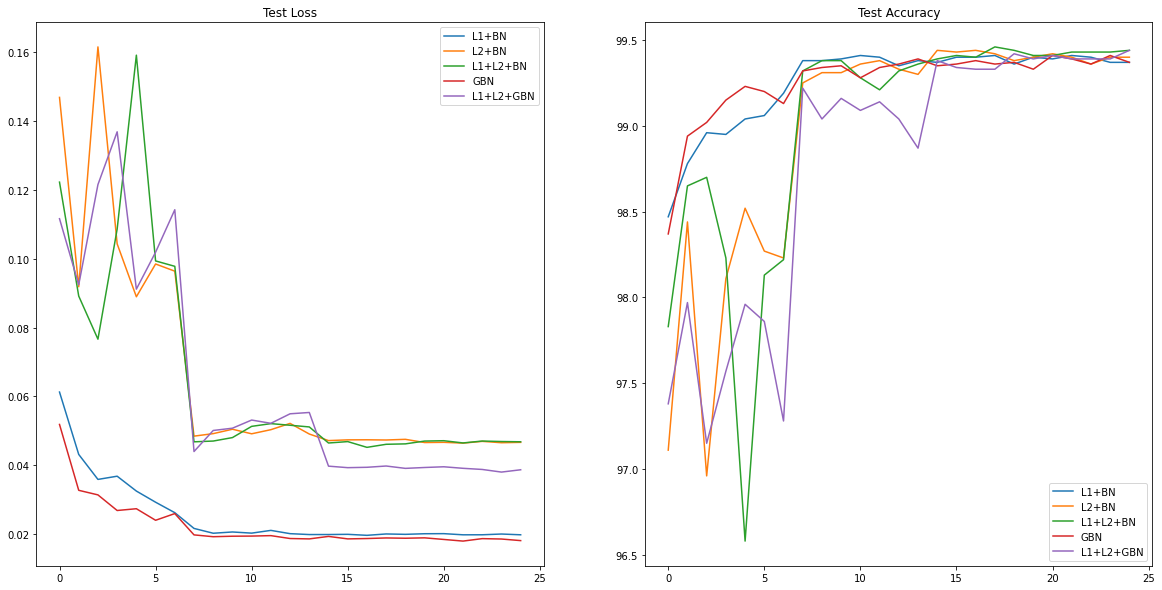

In [14]:
fig, axs = plt.subplots(1,2, figsize=(20,10))
axs[0].plot(test_losses_all[0], label='L1+BN')
axs[0].plot(test_losses_all[1], label='L2+BN')
axs[0].plot(test_losses_all[2], label='L1+L2+BN')
axs[0].plot(test_losses_all[3], label='GBN')
axs[0].plot(test_losses_all[4], label='L1+L2+GBN')
axs[0].set_title('Test Loss')
axs[0].legend()
axs[1].plot(test_acc_all[0], label='L1+BN')
axs[1].plot(test_acc_all[1], label='L2+BN')
axs[1].plot(test_acc_all[2], label='L1+L2+BN')
axs[1].plot(test_acc_all[3], label='GBN')
axs[1].plot(test_acc_all[4], label='L1+L2+GBN')
axs[1].set_title('Test Accuracy')
axs[1].legend()

# Misclassified Images

In [15]:
def plot_misclassified(misclassified):
  fig = plt.figure(figsize = (10,10))
  for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    plt.imshow(misclassified[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
    sub.set_title("Pred={}, Act={}".format(str(misclassified[i][1].data.cpu().numpy()),str(misclassified[i][2].data.cpu().numpy())))
  plt.tight_layout()
  plt.show()

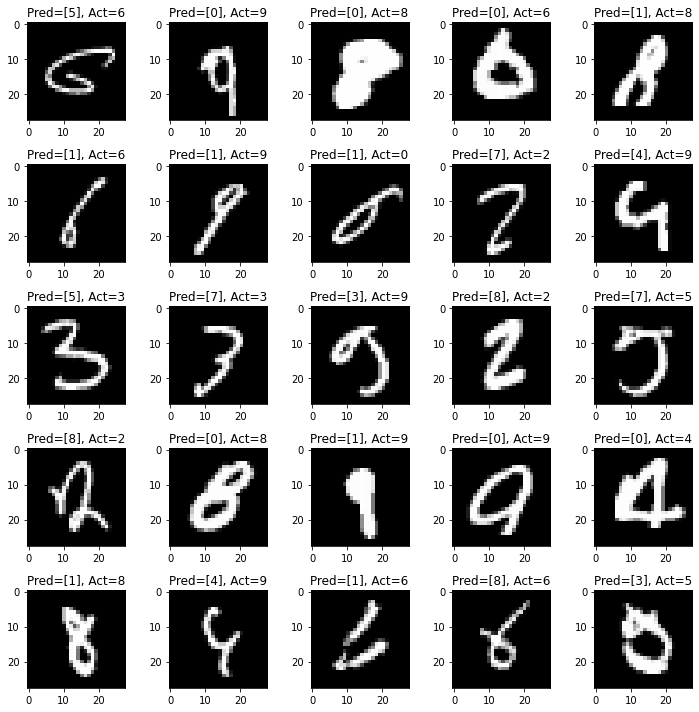

In [17]:
plot_misclassified(misclassified_all[3])

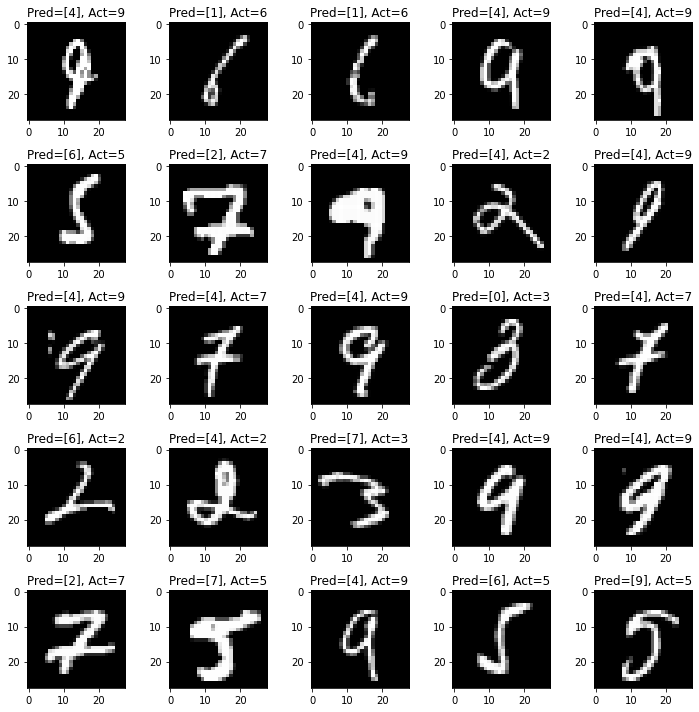

In [16]:
plot_misclassified(misclassified_all[4])